# Particle Swarm Optimization (PSO) Demo

## Nội dung

1. Setup môi trường
2. Giới thiệu PSO
3. Benchmark Functions
4. PSO Examples
5. Visualizations
6. Performance Comparison

## Setup

Cell này sẽ:
- Cài đặt dependencies
- Import tất cả modules cần thiết

In [1]:
# ============================================
# SETUP - Chỉ cần chạy 1 lần
# ============================================

import sys
import subprocess

# Check nếu đang chạy trên Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Đang setup environment trên Google Colab...")
    print("━" * 60)

    # Cài đặt dependencies
    print("\nInstalling dependencies...")
    !pip install -q numpy matplotlib scipy

    print("Dependencies installed!")
    print("\n" + "=" * 60)
    print("Setup complete!")
    print("=" * 60)
else:
    print("Running locally")

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from typing import Callable, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Matplotlib settings
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("\nAll imports successful!")
print("Ready to go!")

Đang setup environment trên Google Colab...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Installing dependencies...
Dependencies installed!

Setup complete!

All imports successful!
Ready to go!


## Code Definitions

Define tất cả classes và functions cần thiết (inline code).

In [2]:
# ============================================
# BENCHMARK FUNCTIONS
# ============================================

class BenchmarkFunction:
    """Base class cho các benchmark functions"""
    def __init__(self, dimension):
        self.dimension = dimension
        self.bounds = None
        self.global_optimum = None
        self.name = "Base Function"

    def __call__(self, x):
        raise NotImplementedError

class SphereFunction(BenchmarkFunction):
    """Sphere Function: f(x) = sum(x_i^2)"""
    def __init__(self, dimension=2):
        super().__init__(dimension)
        self.name = "Sphere Function"
        self.bounds = [(-100, 100)] * dimension
        self.global_optimum = (np.zeros(dimension), 0.0)

    def __call__(self, x):
        return np.sum(x**2)

class RastriginFunction(BenchmarkFunction):
    """Rastrigin Function - Multimodal"""
    def __init__(self, dimension=2):
        super().__init__(dimension)
        self.name = "Rastrigin Function"
        self.bounds = [(-5.12, 5.12)] * dimension
        self.global_optimum = (np.zeros(dimension), 0.0)

    def __call__(self, x):
        n = len(x)
        return 10 * n + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))

class RosenbrockFunction(BenchmarkFunction):
    """Rosenbrock Function - Narrow valley"""
    def __init__(self, dimension=2):
        super().__init__(dimension)
        self.name = "Rosenbrock Function"
        self.bounds = [(-5, 10)] * dimension
        self.global_optimum = (np.ones(dimension), 0.0)

    def __call__(self, x):
        return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

class AckleyFunction(BenchmarkFunction):
    """Ackley Function - Multimodal"""
    def __init__(self, dimension=2):
        super().__init__(dimension)
        self.name = "Ackley Function"
        self.bounds = [(-32.768, 32.768)] * dimension
        self.global_optimum = (np.zeros(dimension), 0.0)

    def __call__(self, x):
        n = len(x)
        sum_sq = np.sum(x**2)
        sum_cos = np.sum(np.cos(2 * np.pi * x))
        term1 = -20 * np.exp(-0.2 * np.sqrt(sum_sq / n))
        term2 = -np.exp(sum_cos / n)
        return term1 + term2 + 20 + np.e

print("✓ Benchmark functions defined")
print("  - Sphere (unimodal, easy)")
print("  - Rastrigin (multimodal, hard)")
print("  - Rosenbrock (narrow valley)")
print("  - Ackley (multimodal)")

✓ Benchmark functions defined
  - Sphere (unimodal, easy)
  - Rastrigin (multimodal, hard)
  - Rosenbrock (narrow valley)
  - Ackley (multimodal)


In [3]:
# ============================================
# PSO ALGORITHM
# ============================================

class Particle:
    """Đại diện cho một particle trong bầy đàn"""
    def __init__(self, dimension: int, bounds: List[Tuple[float, float]]):
        self.dimension = dimension
        self.bounds = bounds

        # Khởi tạo vị trí và vận tốc ngẫu nhiên
        self.position = np.array([
            np.random.uniform(bounds[i][0], bounds[i][1])
            for i in range(dimension)
        ])

        self.velocity = np.array([
            np.random.uniform(-abs(bounds[i][1] - bounds[i][0]),
                            abs(bounds[i][1] - bounds[i][0]))
            for i in range(dimension)
        ])

        self.best_position = self.position.copy()
        self.best_value = float('inf')
        self.current_value = float('inf')

    def update_velocity(self, global_best_position: np.ndarray,
                       w: float, c1: float, c2: float):
        """Cập nhật vận tốc theo công thức PSO"""
        r1 = np.random.random(self.dimension)
        r2 = np.random.random(self.dimension)

        cognitive = c1 * r1 * (self.best_position - self.position)
        social = c2 * r2 * (global_best_position - self.position)

        self.velocity = w * self.velocity + cognitive + social

    def update_position(self):
        """Cập nhật vị trí và đảm bảo trong bounds"""
        self.position = self.position + self.velocity

        # Giới hạn trong bounds
        for i in range(self.dimension):
            if self.position[i] < self.bounds[i][0]:
                self.position[i] = self.bounds[i][0]
                self.velocity[i] *= -0.5
            elif self.position[i] > self.bounds[i][1]:
                self.position[i] = self.bounds[i][1]
                self.velocity[i] *= -0.5

    def evaluate(self, objective_function: Callable):
        """Đánh giá fitness"""
        self.current_value = objective_function(self.position)

        if self.current_value < self.best_value:
            self.best_value = self.current_value
            self.best_position = self.position.copy()

        return self.current_value


class PSO:
    """Particle Swarm Optimization Algorithm"""
    def __init__(self, objective_function: Callable, dimension: int,
                 bounds: List[Tuple[float, float]], n_particles: int = 30,
                 max_iterations: int = 100, w: float = 0.7,
                 c1: float = 1.5, c2: float = 1.5, verbose: bool = True):
        self.objective_function = objective_function
        self.dimension = dimension
        self.bounds = bounds
        self.n_particles = n_particles
        self.max_iterations = max_iterations
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.verbose = verbose

        # Khởi tạo bầy đàn
        self.particles = [Particle(dimension, bounds) for _ in range(n_particles)]

        self.global_best_position = None
        self.global_best_value = float('inf')

        self.history = {
            'best_values': [],
            'mean_values': [],
            'positions': []
        }

    def optimize(self) -> Tuple[np.ndarray, float]:
        """Chạy thuật toán PSO"""
        for iteration in range(self.max_iterations):
            current_values = []

            # Đánh giá tất cả particles
            for particle in self.particles:
                value = particle.evaluate(self.objective_function)
                current_values.append(value)

                if value < self.global_best_value:
                    self.global_best_value = value
                    self.global_best_position = particle.position.copy()

            # Lưu lịch sử
            self.history['best_values'].append(self.global_best_value)
            self.history['mean_values'].append(np.mean(current_values))
            self.history['positions'].append([p.position.copy() for p in self.particles])

            # In thông tin
            if self.verbose and (iteration % 10 == 0 or iteration == self.max_iterations - 1):
                print(f"Iter {iteration + 1}/{self.max_iterations}: "
                      f"Best = {self.global_best_value:.6f}, "
                      f"Mean = {np.mean(current_values):.6f}")

            # Cập nhật particles
            for particle in self.particles:
                particle.update_velocity(self.global_best_position, self.w, self.c1, self.c2)
                particle.update_position()

        return self.global_best_position, self.global_best_value


class AdaptivePSO(PSO):
    """PSO với adaptive inertia weight"""
    def __init__(self, *args, w_start: float = 0.9, w_end: float = 0.4, **kwargs):
        super().__init__(*args, **kwargs)
        self.w_start = w_start
        self.w_end = w_end

    def optimize(self) -> Tuple[np.ndarray, float]:
        """Chạy PSO với adaptive w"""
        for iteration in range(self.max_iterations):
            # Adaptive inertia weight
            self.w = self.w_start - (self.w_start - self.w_end) * iteration / self.max_iterations

            current_values = []
            for particle in self.particles:
                value = particle.evaluate(self.objective_function)
                current_values.append(value)

                if value < self.global_best_value:
                    self.global_best_value = value
                    self.global_best_position = particle.position.copy()

            self.history['best_values'].append(self.global_best_value)
            self.history['mean_values'].append(np.mean(current_values))
            self.history['positions'].append([p.position.copy() for p in self.particles])

            if self.verbose and (iteration % 10 == 0 or iteration == self.max_iterations - 1):
                print(f"Iter {iteration + 1}/{self.max_iterations}: "
                      f"Best = {self.global_best_value:.6f}, "
                      f"w = {self.w:.3f}")

            for particle in self.particles:
                particle.update_velocity(self.global_best_position, self.w, self.c1, self.c2)
                particle.update_position()

        return self.global_best_position, self.global_best_value

print("\n✓ PSO classes defined")
print("  - Particle (individual particle)")
print("  - PSO (standard algorithm)")
print("  - AdaptivePSO (với w giảm dần)")


✓ PSO classes defined
  - Particle (individual particle)
  - PSO (standard algorithm)
  - AdaptivePSO (với w giảm dần)


---

# Demo

Demo và experiments

## Benchmark Functions

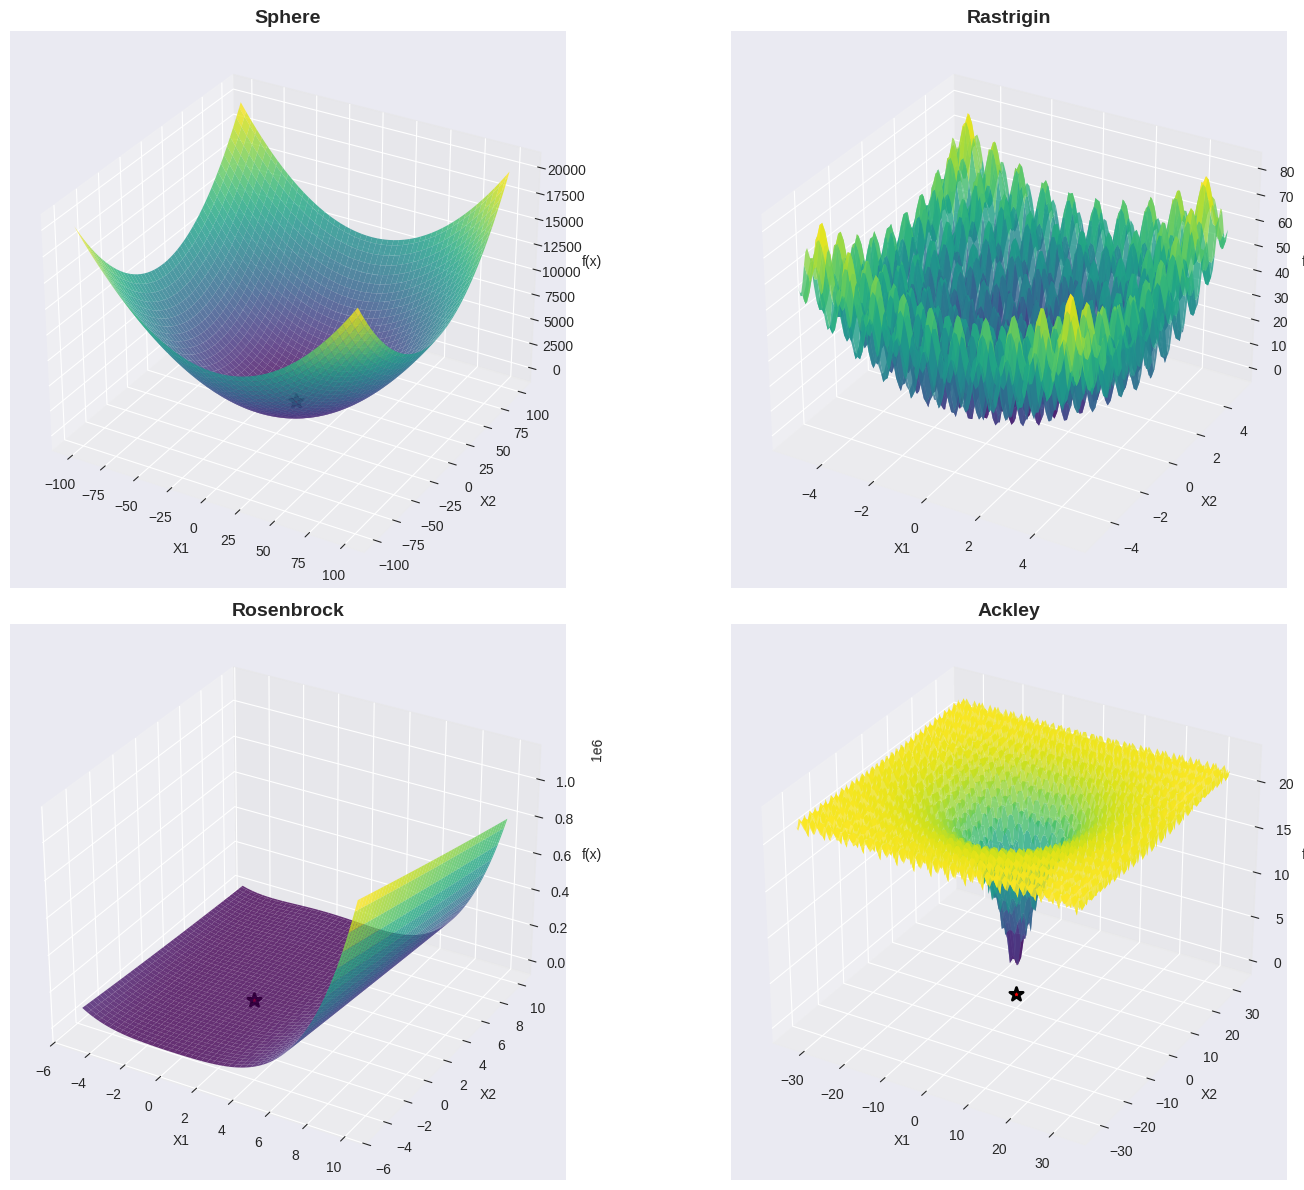


📊 Benchmark Functions:
  • Sphere: Global min = 0.0
  • Rastrigin: Global min = 0.0
  • Rosenbrock: Global min = 0.0
  • Ackley: Global min = 0.0


In [4]:
# Vẽ các benchmark functions
functions = {
    'Sphere': SphereFunction(2),
    'Rastrigin': RastriginFunction(2),
    'Rosenbrock': RosenbrockFunction(2),
    'Ackley': AckleyFunction(2)
}

fig = plt.figure(figsize=(16, 12))

for idx, (name, func) in enumerate(functions.items(), 1):
    bounds = func.bounds

    # Create grid
    x = np.linspace(bounds[0][0], bounds[0][1], 100)
    y = np.linspace(bounds[1][0], bounds[1][1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(100):
        for j in range(100):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

    # 3D plot
    ax = fig.add_subplot(2, 2, idx, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, edgecolor='none')

    # Mark optimum
    opt_pos = func.global_optimum[0]
    if len(opt_pos) == 2:
        opt_val = func(opt_pos)
        ax.scatter([opt_pos[0]], [opt_pos[1]], [opt_val],
                  c='red', s=100, marker='*', edgecolors='black', linewidths=2)

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('f(x)')
    ax.set_title(name, fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

print("\n📊 Benchmark Functions:")
for name, func in functions.items():
    print(f"  • {name}: Global min = {func.global_optimum[1]}")

## Ví dụ 1: PSO trên Sphere Function

In [5]:
print("="*60)
print("PSO on Sphere Function")
print("="*60)

func = SphereFunction(dimension=2)

pso = PSO(
    objective_function=func,
    dimension=2,
    bounds=func.bounds,
    n_particles=30,
    max_iterations=100,
    w=0.7,
    c1=1.5,
    c2=1.5,
    verbose=True
)

best_pos, best_val = pso.optimize()

print("\n" + "="*60)
print("RESULTS")
print("="*60)
print(f"Best position: {best_pos}")
print(f"Best value: {best_val:.10f}")
print(f"Global optimum: {func.global_optimum[1]}")
print(f"Error: {abs(best_val - func.global_optimum[1]):.10f}")

PSO on Sphere Function
Iter 1/100: Best = 20.781321, Mean = 5731.039030
Iter 11/100: Best = 5.264136, Mean = 3883.201752
Iter 21/100: Best = 0.922947, Mean = 804.817692
Iter 31/100: Best = 0.028392, Mean = 546.381903
Iter 41/100: Best = 0.000999, Mean = 28.339326
Iter 51/100: Best = 0.000003, Mean = 58.181500
Iter 61/100: Best = 0.000002, Mean = 15.715118
Iter 71/100: Best = 0.000000, Mean = 0.185065
Iter 81/100: Best = 0.000000, Mean = 0.123082
Iter 91/100: Best = 0.000000, Mean = 0.003398
Iter 100/100: Best = 0.000000, Mean = 0.001313

RESULTS
Best position: [-9.15246330e-07  9.07272531e-06]
Best value: 0.0000000001
Global optimum: 0.0
Error: 0.0000000001


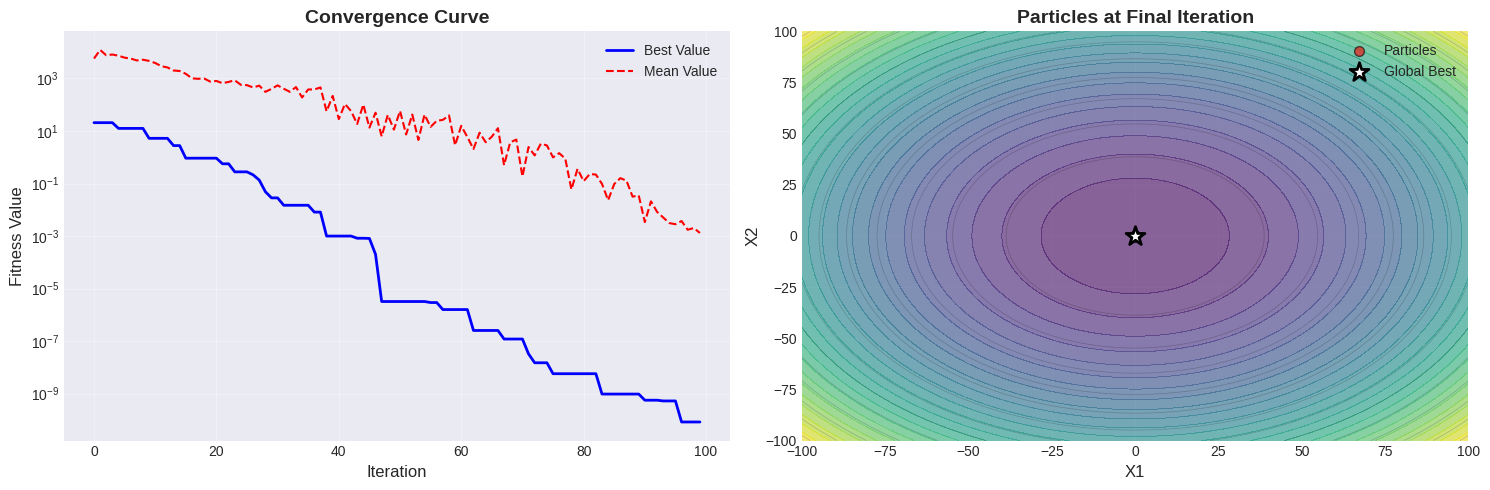

In [6]:
# Plot convergence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Convergence curve
ax1.plot(pso.history['best_values'], 'b-', linewidth=2, label='Best Value')
ax1.plot(pso.history['mean_values'], 'r--', linewidth=1.5, label='Mean Value')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Fitness Value', fontsize=12)
ax1.set_title('Convergence Curve', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# 2D Contour với particles
x = np.linspace(func.bounds[0][0], func.bounds[0][1], 100)
y = np.linspace(func.bounds[1][0], func.bounds[1][1], 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(100):
    for j in range(100):
        Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

contour = ax2.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.6)
ax2.contour(X, Y, Z, levels=15, colors='black', alpha=0.2, linewidths=0.5)

# Plot particles (final positions)
final_positions = pso.history['positions'][-1]
particles_x = [p[0] for p in final_positions]
particles_y = [p[1] for p in final_positions]
ax2.scatter(particles_x, particles_y, c='red', s=50, alpha=0.6,
           edgecolors='black', label='Particles')

# Plot global best
ax2.scatter(best_pos[0], best_pos[1], c='white', s=200, marker='*',
           edgecolors='black', linewidths=2, label='Global Best', zorder=5)

ax2.set_xlabel('X1', fontsize=12)
ax2.set_ylabel('X2', fontsize=12)
ax2.set_title('Particles at Final Iteration', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Ví dụ 2: Adaptive PSO trên Rastrigin (Multimodal)

In [7]:
print("="*60)
print("Adaptive PSO on Rastrigin Function")
print("="*60)

rastrigin = RastriginFunction(dimension=2)

pso_r = AdaptivePSO(
    objective_function=rastrigin,
    dimension=2,
    bounds=rastrigin.bounds,
    n_particles=50,
    max_iterations=200,
    w_start=0.9,
    w_end=0.4,
    c1=2.0,
    c2=2.0,
    verbose=True
)

best_pos_r, best_val_r = pso_r.optimize()

print("\n" + "="*60)
print("RESULTS")
print("="*60)
print(f"Best position: {best_pos_r}")
print(f"Best value: {best_val_r:.10f}")
print(f"Error: {abs(best_val_r):.10f}")

if best_val_r < 1.0:
    print("\n✓ Excellent! Tìm được global optimum region")
elif best_val_r < 10.0:
    print("\n○ Good! Tìm được near-optimal solution")
else:
    print("\n△ Hội tụ về local minimum")

Adaptive PSO on Rastrigin Function
Iter 1/200: Best = 11.707705, w = 0.900
Iter 11/200: Best = 2.475589, w = 0.875
Iter 21/200: Best = 2.475589, w = 0.850
Iter 31/200: Best = 2.475589, w = 0.825
Iter 41/200: Best = 1.428453, w = 0.800
Iter 51/200: Best = 1.428453, w = 0.775
Iter 61/200: Best = 1.428453, w = 0.750
Iter 71/200: Best = 1.303097, w = 0.725
Iter 81/200: Best = 0.246206, w = 0.700
Iter 91/200: Best = 0.007552, w = 0.675
Iter 101/200: Best = 0.004535, w = 0.650
Iter 111/200: Best = 0.004535, w = 0.625
Iter 121/200: Best = 0.000334, w = 0.600
Iter 131/200: Best = 0.000001, w = 0.575
Iter 141/200: Best = 0.000000, w = 0.550
Iter 151/200: Best = 0.000000, w = 0.525
Iter 161/200: Best = 0.000000, w = 0.500
Iter 171/200: Best = 0.000000, w = 0.475
Iter 181/200: Best = 0.000000, w = 0.450
Iter 191/200: Best = 0.000000, w = 0.425
Iter 200/200: Best = 0.000000, w = 0.403

RESULTS
Best position: [-9.46286624e-10  1.05264542e-08]
Best value: 0.0000000000
Error: 0.0000000000

✓ Excellen

## So sánh: Standard PSO vs Adaptive PSO

Comparing Standard PSO vs Adaptive PSO
Function: Rosenbrock (narrow valley)

[1] Standard PSO...
Best value: 0.000000

[2] Adaptive PSO...
Best value: 0.000000

COMPARISON
Standard PSO:  0.000000
Adaptive PSO:  0.000000
Improvement:   -1602.64%


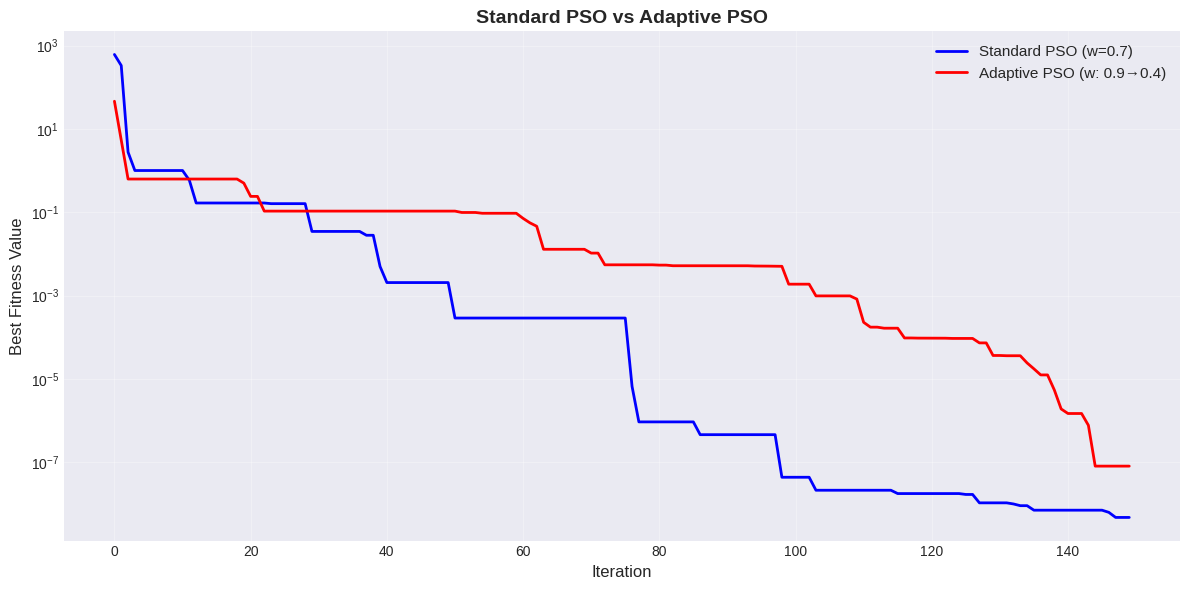

In [8]:
test_func = RosenbrockFunction(dimension=2)

print("Comparing Standard PSO vs Adaptive PSO")
print("Function: Rosenbrock (narrow valley)")
print("="*60)

# Standard PSO
print("\n[1] Standard PSO...")
pso_std = PSO(
    objective_function=test_func,
    dimension=2,
    bounds=test_func.bounds,
    n_particles=40,
    max_iterations=150,
    w=0.7,
    c1=1.5,
    c2=1.5,
    verbose=False
)
pos_std, val_std = pso_std.optimize()
print(f"Best value: {val_std:.6f}")

# Adaptive PSO
print("\n[2] Adaptive PSO...")
pso_adp = AdaptivePSO(
    objective_function=test_func,
    dimension=2,
    bounds=test_func.bounds,
    n_particles=40,
    max_iterations=150,
    w_start=0.9,
    w_end=0.4,
    c1=1.5,
    c2=1.5,
    verbose=False
)
pos_adp, val_adp = pso_adp.optimize()
print(f"Best value: {val_adp:.6f}")

print("\n" + "="*60)
print("COMPARISON")
print("="*60)
print(f"Standard PSO:  {val_std:.6f}")
print(f"Adaptive PSO:  {val_adp:.6f}")
print(f"Improvement:   {((val_std - val_adp) / val_std * 100):.2f}%")

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(pso_std.history['best_values'], 'b-', linewidth=2, label='Standard PSO (w=0.7)')
ax.plot(pso_adp.history['best_values'], 'r-', linewidth=2, label='Adaptive PSO (w: 0.9→0.4)')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Best Fitness Value', fontsize=12)
ax.set_title('Standard PSO vs Adaptive PSO', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.tight_layout()
plt.show()

## Performance trên tất cả Functions

Testing PSO on all benchmark functions
Trials per function: 3

Testing Sphere...
  Trial 1: 0.000000
  Trial 2: 0.000000
  Trial 3: 0.000000

Testing Rastrigin...
  Trial 1: 0.000000
  Trial 2: 0.000000
  Trial 3: 0.000000

Testing Rosenbrock...
  Trial 1: 0.000081
  Trial 2: 0.000012
  Trial 3: 0.000004

Testing Ackley...
  Trial 1: 0.000000
  Trial 2: 0.000000
  Trial 3: 0.000013

SUMMARY
Function        Best            Mean            Std            
----------------------------------------------------------------------
Sphere          2.472918e-13    3.562668e-12    3.538057e-12   
Rastrigin       4.243361e-11    1.281068e-09    1.675504e-09   
Rosenbrock      4.006658e-06    3.240663e-05    3.482100e-05   
Ackley          8.853622e-08    4.459604e-06    6.120580e-06   


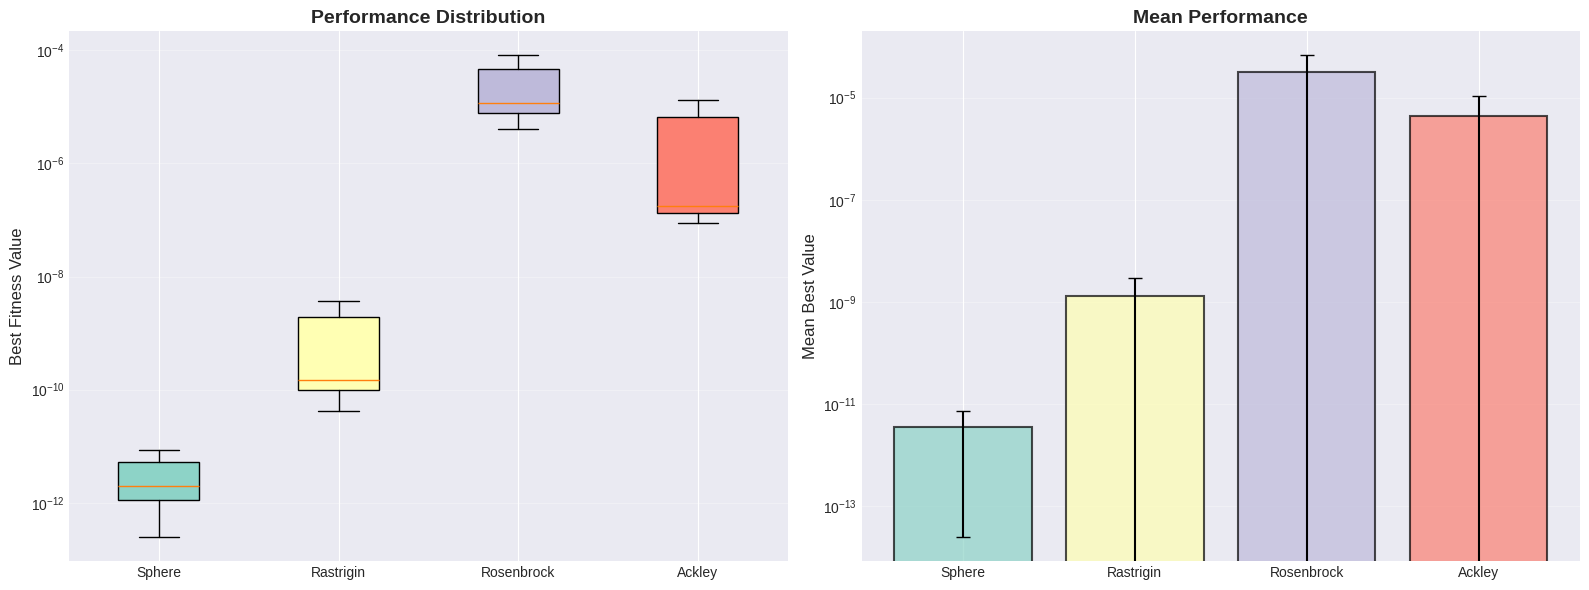

In [9]:
all_functions = {
    'Sphere': SphereFunction(2),
    'Rastrigin': RastriginFunction(2),
    'Rosenbrock': RosenbrockFunction(2),
    'Ackley': AckleyFunction(2)
}

results = {}
n_trials = 3

print("Testing PSO on all benchmark functions")
print(f"Trials per function: {n_trials}")
print("="*70)

for name, func in all_functions.items():
    print(f"\nTesting {name}...")
    trial_results = []

    for trial in range(n_trials):
        pso = AdaptivePSO(
            objective_function=func,
            dimension=2,
            bounds=func.bounds,
            n_particles=50,
            max_iterations=150,
            w_start=0.9,
            w_end=0.4,
            c1=2.0,
            c2=2.0,
            verbose=False
        )
        _, best_val = pso.optimize()
        trial_results.append(best_val)
        print(f"  Trial {trial+1}: {best_val:.6f}")

    results[name] = {
        'values': trial_results,
        'mean': np.mean(trial_results),
        'std': np.std(trial_results),
        'min': np.min(trial_results)
    }

# Summary table
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"{'Function':<15} {'Best':<15} {'Mean':<15} {'Std':<15}")
print("-"*70)
for name, res in results.items():
    print(f"{name:<15} {res['min']:<15.6e} {res['mean']:<15.6e} {res['std']:<15.6e}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
names = list(results.keys())
data = [results[k]['values'] for k in names]
bp = ax1.boxplot(data, labels=names, patch_artist=True)
colors = plt.cm.Set3(range(len(data)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_ylabel('Best Fitness Value', fontsize=12)
ax1.set_title('Performance Distribution', fontsize=14, fontweight='bold')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3, axis='y')

# Bar chart
means = [results[k]['mean'] for k in names]
stds = [results[k]['std'] for k in names]
x_pos = np.arange(len(names))
bars = ax2.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7,
              color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Mean Best Value', fontsize=12)
ax2.set_title('Mean Performance', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(names)
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Thử nghiệm

Modify parameters và thử nghiệm tự do:

Running your custom PSO...
Iter 1/200: Best = 9.735033, w = 0.900
Iter 11/200: Best = 2.738288, w = 0.875
Iter 21/200: Best = 2.738288, w = 0.850
Iter 31/200: Best = 2.539480, w = 0.825
Iter 41/200: Best = 2.137542, w = 0.800
Iter 51/200: Best = 1.870197, w = 0.775
Iter 61/200: Best = 1.870197, w = 0.750
Iter 71/200: Best = 1.817463, w = 0.725
Iter 81/200: Best = 1.504059, w = 0.700
Iter 91/200: Best = 1.074862, w = 0.675
Iter 101/200: Best = 0.971517, w = 0.650
Iter 111/200: Best = 0.102732, w = 0.625
Iter 121/200: Best = 0.013127, w = 0.600
Iter 131/200: Best = 0.002367, w = 0.575
Iter 141/200: Best = 0.000349, w = 0.550
Iter 151/200: Best = 0.000018, w = 0.525
Iter 161/200: Best = 0.000001, w = 0.500
Iter 171/200: Best = 0.000000, w = 0.475
Iter 181/200: Best = 0.000000, w = 0.450
Iter 191/200: Best = 0.000000, w = 0.425
Iter 200/200: Best = 0.000000, w = 0.403

YOUR RESULTS
Function: Rastrigin Function
Best position: [ 9.24261189e-09 -1.88481122e-08]
Best value: 8.526512829121202e-

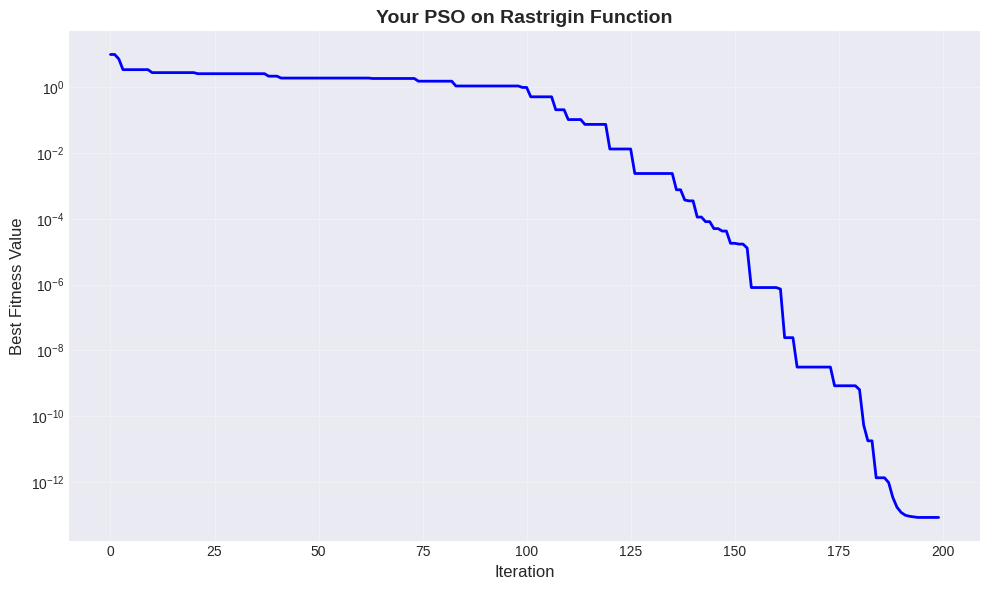

In [10]:
# ============================================
# PLAYGROUND - THỬ NGHIỆM CỦA BẠN
# ============================================

# Chọn function (Sphere, Rastrigin, Rosenbrock, Ackley)
my_func = RastriginFunction(dimension=2)

# Tạo PSO với parameters của bạn
my_pso = AdaptivePSO(
    objective_function=my_func,
    dimension=2,
    bounds=my_func.bounds,
    n_particles=50,        # Thử thay đổi
    max_iterations=200,    # Thử thay đổi
    w_start=0.9,          # Thử thay đổi
    w_end=0.4,            # Thử thay đổi
    c1=2.0,               # Thử thay đổi
    c2=2.0,               # Thử thay đổi
    verbose=True
)

# Chạy
print("Running your custom PSO...")
print("="*60)
best_pos, best_val = my_pso.optimize()

print("\n" + "="*60)
print("YOUR RESULTS")
print("="*60)
print(f"Function: {my_func.name}")
print(f"Best position: {best_pos}")
print(f"Best value: {best_val}")
print(f"Global optimum: {my_func.global_optimum[1]}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(my_pso.history['best_values'], 'b-', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Best Fitness Value', fontsize=12)
plt.title(f'Your PSO on {my_func.name}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

---

## Kết luận

### Những điểm chính:

1. **PSO hiệu quả** cho bài toán tối ưu hóa
2. **Adaptive PSO** thường tốt hơn Standard PSO
3. **Parameters** quan trọng: w, c1, c2, n_particles
4. **Functions khác nhau** → độ khó khác nhau